[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/NeuromatchAcademy/course-content-dl/blob/main/projects/Neuroscience/pose_estimation.ipynb)
[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/projects/Neuroscience/pose_estimation.ipynb)

# Animal Pose Estimation
**By Neuromatch Academy**

__Content creators:__ Kristin Branson

__Produtction editors:__ Gagana B, Spiros Chavlis

---
# Objectives

Train a deep network that can predict the locations of parts of animals. This Colab Notebook has all the code necessary to train a UNet network to predict the positions of 17 parts on a fruit fly.

**Project ideas:**

1. (easy-medium) Improve the pose estimator. Some possible ideas to explore:
  * (easy) Data augmentation: It is common to train a network to be robust to certain kinds of perturbations by adding random perturbations to the training data. Try modifying the COCODataset to perform data augmentation. The mmpose toolkit has some data transforms relevant for pose tracking here
[https://github.com/open-mmlab/mmpose/blob/b0acfc423da672e61db75e00df9da106b6ead574/mmpose/datasets/pipelines/top_down_transform.py](https://github.com/open-mmlab/mmpose/blob/b0acfc423da672e61db75e00df9da106b6ead574/mmpose/datasets/pipelines/top_down_transform.py)
  * (medium) Network architecture: There are tons of networks people have designed for pose estimation. The mmpose toolbox has many networks implemented:
[https://github.com/open-mmlab/mmpose](https://github.com/open-mmlab/mmpose). Can you improve the accuracy with more exotic networks than the UNet? To do this, you should define a new network class, similar to the definition of [UNet](https://colab.research.google.com/drive/1SLgOHcgo1bfMDx5wlnLqm05AZe6aVG0l?authuser=1#scrollTo=Yf4vdxN7v9Rz&line=5&uniqifier=1). If you need a different loss function, you will also need to change the criterion used for training.
  * (easy to medium) Optimization algorithm: Feed-forward convolutional networks have been engineered (e.g. by adding batch normalization layers) to be pretty robust to the exact choice of gradient descent algorithm, but there is still room for improvement in this code.
  * Other ideas? Look at the errors the network is making -- how might we improve the tracker?
  * (medium) Our training data set was relatively large -- 4216 examples. Can we get away with less examples than this? Can we change our algorithm to work better with smaller data sets? One idea to look into is pre-training the network on a different data set.
  * Note: The data provided consists of both a training and a test set. It is important to not overfit to the test set, and only use it for a final evaluation. This code splits the training set into a training and a validation data set. Use this split data for testing out different algorithms. Then, after you finish developing your algorithm you can evaluate it on the test data.
2. (easy) Train a pose estimator for a different data set.
  * This Notebook has code for training a fly part tracker. More animal pose data sets can be found here: [https://mmpose.readthedocs.io/en/latest/tasks/2d_animal_keypoint.html](https://mmpose.readthedocs.io/en/0.x/tasks/2d_animal_keypoint.html)
  * You can label your own dataset using animal tracking software like
  DeepLabCut [http://www.mackenziemathislab.org/deeplabcut](http://www.mackenziemathislab.org/deeplabcut)
  or APT [http://kristinbranson.github.io/APT/](http://kristinbranson.github.io/APT/)
  * To use a different data set, you might need to make a new Dataset class similar to our COCODataset class.
3. (medium) Explore how well the network generalizes to data collected in other labs. Can you train a pose estimator that works on lots of different types of data?
3. (easy) Explore using tensorboard with this network. Tensorboard lets you monitor and visualize training, and is an important tool as you develop and debug algorithms. A tutorial on using Tensorboard is here
[https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html](https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html)
A Colab Notebook using tensorboard is here:
[https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/tensorboard_with_pytorch.ipynb](https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/tensorboard_with_pytorch.ipynb)
4. (hard) Explore how the network is making its decisions using explainable AI techniques.

Acknowledgments:
This Notebook was developed by Kristin Branson. It borrows from:
* APT [https://github.com/kristinbranson/APT](https://github.com/kristinbranson/APT)
* Milesi Alexandre's UNet implementation [https://github.com/milesial/Pytorch-UNet](https://github.com/milesial/Pytorch-UNet)

---
# Setup

In [1]:
# @title Install dependencies
!pip install opencv-python --quiet
!pip install google.colab --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 39.6 MB/s eta 0:00:00


In [2]:
# Imports
import re
import os
import cv2
import json
import torch
import torchvision

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import torch.nn as nn
from torch import optim
import torch.nn.functional as F

from tqdm import tqdm
from glob import glob

In [3]:
# @title Helper function
def PlotLabelAndPrediction(batch, hm_pred, idx=None, title_string=''):
  """
  PlotLabelAndPrediction(batch,pred,idx=None):
  Plot the input, labels, and predictions for a batch.
  """
  isbatch = isinstance(batch['id'], torch.Tensor)

  if idx is None and isbatch:
    idx = range(len(batch['id']))
  if isbatch:
    n = len(idx)
  else:
    n = 1
    idx = [None,]
  locs_pred = heatmap2landmarks(hm_pred.cpu().numpy())
  for i in range(n):

    plt.subplot(n, 4, 4*i + 1)
    im = COCODataset.get_image(batch, idx[i])
    plt.imshow(im,cmap='gray')
    locs = COCODataset.get_landmarks(batch, idx[i])
    for k in range(train_dataset.nlandmarks):
      plt.plot(locs[k, 0], locs[k, 1],
               marker='.', color=colors[k],
               markerfacecolor=colors[k])
    if isbatch:
      batchid = batch['id'][i]
    else:
      batchid = batch['id']
    plt.title(f"{title_string}{batchid}")

    plt.subplot(n, 4, 4*i + 2)
    plt.imshow(im,cmap='gray')
    locs = COCODataset.get_landmarks(batch, idx[i])
    if isbatch:
      locs_pred_curr = locs_pred[i, ...]
    else:
      locs_pred_curr = locs_pred
    for k in range(train_dataset.nlandmarks):
      plt.plot(locs_pred_curr[k, 0], locs_pred_curr[k, 1],
               marker='.', color=colors[k],
               markerfacecolor=colors[k])
    if i == 0: plt.title('pred')

    plt.subplot(n, 4, 4*i + 3)
    hmim = COCODataset.get_heatmap_image(batch, idx[i])
    plt.imshow(hmim)
    if i == 0: plt.title('label')

    plt.subplot(n, 4, 4*i + 4)
    if isbatch:
      predcurr = hm_pred[idx[i], ...]
    else:
      predcurr = hm_pred
    plt.imshow(heatmap2image(predcurr.cpu().numpy(), colors=colors))
    if i == 0: plt.title('pred')

In [4]:
print(f"numpy version: {np.__version__}")
print(f"\nCUDA available: {torch.cuda.is_available()}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\ntorch version: {torch.__version__}")

numpy version: 2.0.2

CUDA available: True

torch version: 2.6.0+cu124


In [5]:
# @title Download the data
import os, requests, tarfile

fname = 'fly_bubble_20201204.tar.gz'
url = 'https://osf.io/q7vhy/download'
datadir = 'view0'

if not os.path.exists(fname):
  r = requests.get(url, allow_redirects=True)
  with open(fname, 'wb') as ftar:
    ftar.write(r.content)
  print('Fly pose data have been downloaded.')

# Untar fly pose data
if not os.path.exists(datadir):
  with tarfile.open(fname, 'r') as f:
    f.extractall('.')  # specify which folder to extract to
    # remove tar file
    os.remove(fname)
    print('Fly pose data have been unzipped.')
else:
  print('Fly pose data already unzipped.')

Fly pose data have been downloaded.
Fly pose data have been unzipped.


---
# Mount your gDrive

Get the pose data set. To do this, you need to make a shortcut to a shared Google Drive directory in your Google Drive.

1.   Go to the shared Google Drive: [https://drive.google.com/drive/folders/1a06ZAmQXvUqZZQGI9XWWjABl4vOF8v6Z?usp=sharing](https://drive.google.com/drive/folders/1a06ZAmQXvUqZZQGI9XWWjABl4vOF8v6Z?usp=sharing)
2.   Select "Add shortcut to Drive" and select "My Drive".

<img src="https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/projects/static/Screenshot_AddShortcutToPoseData.png">



In [6]:
gDrive = False

In [7]:
# @markdown set the `gDrive=True` and run the cell.
from google.colab import drive

if gDrive:
  print('The first time you run this, it will ask you to verify that Google Colab can access your Google Drive.')
  print('Follow the instructions -- go to the linked website, and copy-paste the provided code.')
  drive.flush_and_unmount()
  drive.mount('/content/drive', force_remount=True)
  assert os.path.exists('/content/drive/My Drive'), 'Google drive not mounted'

  # Unzip fly pose data
  datadir = 'view0'
  if not os.path.exists(datadir):
    assert os.path.exists('/content/drive/My Drive/fly_bubble_pose/fly_bubble_20201204.tar.gz'), 'Fly pose data zip file not found'
    !tar -xvzf '/content/drive/My Drive/fly_bubble_pose/fly_bubble_20201204.tar.gz' > /dev/null
    assert os.path.exists(datadir), 'view0 not created after unzipping data'
  else:
    print('Fly pose data already unzipped')

In [8]:
# Make sure all the data exists
traindir = os.path.join(datadir, 'train')
trainannfile = os.path.join(datadir, 'train_annotations.json')
testdir = os.path.join(datadir, 'test')
testannfile = os.path.join(datadir, 'test_annotations.json')
assert os.path.exists(traindir) and os.path.exists(testdir) and os.path.exists(trainannfile) and os.path.exists(testannfile), 'Could not find all necessary data after unzipping'
print('Found all the fly pose data')

# Read annotation information
with open(trainannfile) as f:
  trainann = json.load(f)
f.close()
ntrainims = len(trainann['images'])
# Make sure we have all the images
t = glob(os.path.join(traindir,'*.png'))
print(f"N. train images = {ntrainims}, number of images unzipped = {len(t)}")
assert ntrainims == len(t), 'number of annotations and number of images do not match'

# get some features of the data set
i = 0
filestr = trainann['images'][0]['file_name']
imfile = os.path.join(traindir,filestr)
im = cv2.imread(imfile, cv2.IMREAD_UNCHANGED)
imsize = im.shape
if len(imsize) == 2:
  imsize += (1, )
print(f"input image size: {imsize}")

landmark_names = ['head_fc', 'head_bl', 'head_br', 'thorax_fr', 'thorax_fl',
                  'thorax_bc', 'abdomen', 'leg_ml_in', 'leg_ml_c',' leg_mr_in',
                  'leg_mr_c', 'leg_fl_tip', 'leg_ml_tip', 'leg_bl_tip',
                  'leg_br_tip','leg_mr_tip','leg_fr_tip']
nlandmarks = trainann['annotations'][0]['num_keypoints']
assert nlandmarks == len(landmark_names)

Found all the fly pose data
N. train images = 4216, number of images unzipped = 4216
input image size: (181, 181, 1)


---
# Visulaize the data

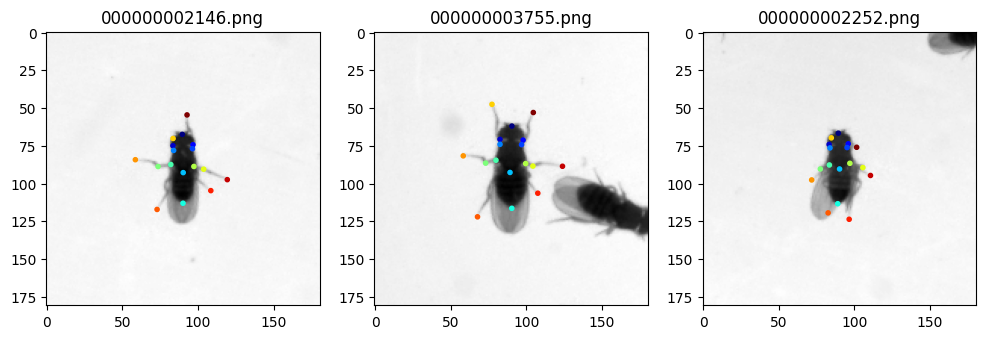

In [9]:
# Show some example images
nimsshow = 3  # number of images to plot
imsshow = np.random.choice(ntrainims,nimsshow)
fig = plt.figure(figsize=(4*nimsshow, 4), dpi=100)  # make the figure bigger
for i in range(nimsshow):
  filestr = trainann['images'][imsshow[i]]['file_name']
  imfile = os.path.join(traindir, filestr)
  im = cv2.imread(imfile, cv2.IMREAD_UNCHANGED)
  plt.subplot(1,nimsshow,i+1)
  plt.imshow(im,cmap='gray')
  x = trainann['annotations'][imsshow[i]]['keypoints'][::3]
  y = trainann['annotations'][imsshow[i]]['keypoints'][1::3]
  plt.scatter(x, y, marker='.', c=np.arange(nlandmarks), cmap='jet')
  plt.title(filestr)
plt.show()

In [10]:
# define a dataset class to load the data

def heatmap2image(hm, cmap='jet', colors=None):
  """
  heatmap2image(hm,cmap='jet',colors=None)
  Creates and returns an image visualization from landmark heatmaps. Each
  landmark is colored according to the input cmap/colors.
  Inputs:
    hm: nlandmarks x height x width ndarray, dtype=float in the range 0 to 1.
    hm[p,i,j] is a score indicating how likely it is that the pth landmark
    is at pixel location (i,j).
    cmap: string.
    Name of colormap for defining colors of landmark points. Used only if colors
    is None.
    Default: 'jet'
    colors: list of length nlandmarks.
    colors[p] is an ndarray of size (4,) indicating the color to use for the
    pth landmark. colors is the output of matplotlib's colormap functions.
    Default: None
  Output:
    im: height x width x 3 ndarray
    Image representation of the input heatmap landmarks.
  """
  hm = np.maximum(0., np.minimum(1. ,hm))
  im = np.zeros((hm.shape[1], hm.shape[2], 3))
  if colors is None:
    if isinstance(cmap, str):
      cmap = matplotlib.cm.get_cmap(cmap)
    colornorm = matplotlib.colors.Normalize(vmin=0, vmax=hm.shape[0])
    colors = cmap(colornorm(np.arange(hm.shape[0])))
  for i in range(hm.shape[0]):
    color = colors[i]
    for c in range(3):
      im[..., c] = im[..., c] + (color[c] * .7 + .3) * hm[i, ...]
  im = np.minimum(1.,im)

  return im


class COCODataset(torch.utils.data.Dataset):
  """
  COCODataset
  Torch Dataset based on the COCO keypoint file format.
  """

  def __init__(self, annfile, datadir=None, label_sigma=3.,
               transform=None, landmarks=None):
    """
    Constructor
    This must be defined in every Torch Dataset and can take any inputs you
    want it to.
    Inputs:
      annfile: string
      Path to json file containing annotations.
      datadir: string
      Path to directory containing images. If None, images are assumed to be in
      the working directory.
      Default: None
      label_sigma: scalar float
      Standard deviation in pixels of Gaussian to be used to make the landmark
      heatmap.
      Default: 3.
      transform: None
      Not used currently
      landmarks: ndarray (or list, something used for indexing into ndarray)
      Indices of landmarks available to use in this dataset. Reducing the
      landmarks used can make training faster and require less memory, and is
      useful for testing code. If None, all landmarks are used.
      Default: None
    """

    # read in the annotations from the json file
    with open(annfile) as f:
      self.ann = json.load(f)
    # where the images are
    self.datadir = datadir

    # landmarks to use
    self.nlandmarks_all = self.ann['annotations'][0]['num_keypoints']
    if landmarks is None:
      self.nlandmarks = self.nlandmarks_all
    else:
      self.nlandmarks = len(landmarks)
    self.landmarks = landmarks

    # for data augmentation/rescaling
    self.transform = transform

    # output will be heatmap images, one per landmark, with Gaussian values
    # around the landmark location -- precompute some stuff for that
    self.label_filter = None
    self.label_filter_r = 1
    self.label_filter_d = 3
    self.label_sigma = label_sigma
    self.init_label_filter()

  def __len__(self):
    """
    Overloaded len function.
    This must be defined in every Torch Dataset and must take only self
    as input.
    Returns the number of examples in the dataset.
    """
    return len(self.ann['images'])

  def __getitem__(self, item):
    """
    Overloaded getitem function.
    This must be defined in every Torch Dataset and must take only self
    and item as input. It returns example number item.
    item: scalar integer.
    The output example is a dict with the following fields:
    image: torch float32 tensor of size ncolors x height x width
    landmarks: nlandmarks x 2 float ndarray
    heatmaps: torch float32 tensor of size nlandmarks x height x width
    id: scalar integer, contains item
    """

    # read in the image for training example item
    # and convert to a torch tensor
    filename = self.ann['images'][item]['file_name']
    if self.datadir is not None:
      filename = os.path.join(self.datadir, filename)
    assert os.path.exists(filename)
    im = torch.from_numpy(cv2.imread(filename, cv2.IMREAD_UNCHANGED))

    # convert to float32 in the range 0. to 1.
    if im.dtype == float:
      pass
    elif im.dtype == torch.uint8:
      im = im.float() / 255.
    elif im.dtype == torch.uint16:
      im = im.float() / 65535.
    else:
      print('Cannot handle im type '+str(im.dtype))
      raise TypeError

    imsz = im.shape
    # convert to a tensor of size ncolors x h x w
    if im.dim() == 3:
      im = torch.transpose(im, [2, 0, 1])  # now 3 x h x w
    else:
      im = torch.unsqueeze(im, 0)  # now 1 x h x w

    # landmark locations
    locs = np.reshape(self.ann['annotations'][item]['keypoints'],
                      [self.nlandmarks_all, 3])
    locs = locs[:, :2]
    if self.landmarks is not None:
      locs = locs[self.landmarks, :]

    # create heatmap target prediction
    heatmaps = self.make_heatmap_target(locs, imsz)

    # return a dict with the following fields:
    # image: torch float32 tensor of size ncolors x height x width
    # landmarks: nlandmarks x 2 float ndarray
    # heatmaps: torch float32 tensor of size nlandmarks x height x width
    # id: scalar integer, contains item
    features = {'image':im,
                'landmarks':locs.astype(np.float32),
                'heatmaps':heatmaps,
                'id':item}

    return features

  def init_label_filter(self):
    """
    init_label_filter(self)
    Helper function
    Create a Gaussian filter for the heatmap target output
    """
    # radius of the filter
    self.label_filter_r = max(int(round(3 * self.label_sigma)), 1)
    # diameter of the filter
    self.label_filter_d = 2 * self.label_filter_r + 1

    # allocate
    self.label_filter = np.zeros([self.label_filter_d, self.label_filter_d])
    # set the middle pixel to 1.
    self.label_filter[self.label_filter_r, self.label_filter_r] = 1.
    # blur with a Gaussian
    self.label_filter = cv2.GaussianBlur(self.label_filter,
                                         (self.label_filter_d,
                                          self.label_filter_d),
                                         self.label_sigma)
    # normalize
    self.label_filter = self.label_filter / np.max(self.label_filter)
    # convert to torch tensor
    self.label_filter = torch.from_numpy(self.label_filter)

  def make_heatmap_target(self, locs, imsz):
    """
    make_heatmap_target(self,locs,imsz):
    Helper function
    Creates the heatmap tensor of size imsz corresponding to landmark locations locs
    Inputs:
      locs: nlandmarks x 2 ndarray
      Locations of landmarks
      imsz: image shape
    Returns:
      target: torch tensor of size nlandmarks x imsz[0] x imsz[1]
      Heatmaps corresponding to locs
    """
    # allocate the tensor
    target = torch.zeros((locs.shape[0], imsz[0], imsz[1]), dtype=torch.float32)
    # loop through landmarks
    for i in range(locs.shape[0]):
      # location of this landmark to the nearest pixel
      x = int(np.round(locs[i, 0])) # losing sub-pixel accuracy
      y = int(np.round(locs[i, 1]))
      # edges of the Gaussian filter to place, minding border of image
      x0 = np.maximum(0, x - self.label_filter_r)
      x1 = np.minimum(imsz[1] - 1, x + self.label_filter_r)
      y0 = np.maximum(0, y - self.label_filter_r)
      y1 = np.minimum(imsz[0] - 1, y + self.label_filter_r)
      # crop filter if it goes outside of the image
      fil_x0 = self.label_filter_r - (x - x0)
      fil_x1 = self.label_filter_d - (self.label_filter_r - (x1 - x))
      fil_y0 = self.label_filter_r - (y - y0)
      fil_y1 = self.label_filter_d - (self.label_filter_r - (y1 - y))
      # copy the filter to the relevant part of the heatmap image
      target[i, y0:y1 + 1, x0:x1 + 1] = self.label_filter[fil_y0:fil_y1 + 1,
                                                          fil_x0:fil_x1 + 1]

    return target

  @staticmethod
  def get_image(d, i=None):
    """
    static function, used for visualization
    COCODataset.get_image(d,i=None)
    Returns an image usable with plt.imshow()
    Inputs:
      d: if i is None, item from a COCODataset.
      if i is a scalar, batch of examples from a COCO Dataset returned
      by a DataLoader.
      i: Index of example into the batch d, or None if d is a single example
    Returns the ith image from the patch as an ndarray plottable with
    plt.imshow()
    """
    if i is None:
      im = np.squeeze(np.transpose(d['image'].numpy(), (1, 2, 0)), axis=2)
    else:
      im = np.squeeze(np.transpose(d['image'][i,...].numpy(), (1, 2, 0)), axis=2)
    return im

  @staticmethod
  def get_landmarks(d, i=None):
    """
    static helper function
    COCODataset.get_landmarks(d,i=None)
    Returns a nlandmarks x 2 ndarray indicating landmark locations.
    Inputs:
      d: if i is None, item from a COCODataset.
      if i is a scalar, batch of examples from a COCO Dataset returned
      by a DataLoader.
      i: Index of example into the batch d, or None if d is a single example
    """
    if i is None:
      locs = d['landmarks']
    else:
      locs = d['landmarks'][i]
    return locs

  @staticmethod
  def get_heatmap_image(d, i, cmap='jet', colors=None):
    """
    static function, used for visualization
    COCODataset.get_heatmap_image(d,i=None)
    Returns an image visualization of heatmaps usable with plt.imshow()
    Inputs:
      d: if i is None, item from a COCODataset.
      if i is a scalar, batch of examples from a COCO Dataset returned
      by a DataLoader.
      i: Index of example into the batch d, or None if d is a single example
      Returns the ith heatmap from the patch as an ndarray plottable with
      plt.imshow()
      cmap: string.
      Name of colormap for defining colors of landmark points. Used only if colors
      is None.
      Default: 'jet'
      colors: list of length nlandmarks.
      colors[p] is an ndarray of size (4,) indicating the color to use for the
      pth landmark. colors is the output of matplotlib's colormap functions.
      Default: None
    Output:
      im: height x width x 3 ndarray
      Image representation of the input heatmap landmarks.
    """
    if i is None:
      hm = d['heatmaps']
    else:
      hm = d['heatmaps'][i, ...]
    hm = hm.numpy()
    im = heatmap2image(hm, cmap=cmap, colors=colors)

    return im

/tmp/ipython-input-11-2476673002.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = matplotlib.cm.get_cmap('jet')


{'image': tensor([[[[0.8275, 0.8275, 0.8235,  ..., 0.3608, 0.2863, 0.2235],
          [0.8275, 0.8275, 0.8275,  ..., 0.4000, 0.3137, 0.2471],
          [0.8275, 0.8275, 0.8275,  ..., 0.4431, 0.3490, 0.2706],
          ...,
          [0.8275, 0.8275, 0.8235,  ..., 0.7922, 0.8000, 0.8078],
          [0.8235, 0.8235, 0.8235,  ..., 0.8000, 0.7922, 0.8078],
          [0.8235, 0.8235, 0.8235,  ..., 0.8078, 0.8000, 0.8000]]],


        [[[0.4784, 0.4549, 0.3804,  ..., 0.8314, 0.8314, 0.8275],
          [0.4588, 0.4902, 0.3686,  ..., 0.8353, 0.8314, 0.8314],
          [0.3961, 0.3608, 0.3020,  ..., 0.8353, 0.8275, 0.8314],
          ...,
          [0.8196, 0.8235, 0.8196,  ..., 0.8392, 0.8392, 0.8353],
          [0.8235, 0.8196, 0.8157,  ..., 0.8353, 0.8392, 0.8392],
          [0.8196, 0.8196, 0.8235,  ..., 0.8314, 0.8353, 0.8392]]]]), 'landmarks': tensor([[[ 90.5618,  62.9627],
         [ 82.9773,  72.2327],
         [ 96.1799,  71.9518],
         [ 96.7418,  74.7608],
         [ 83.5391,  74

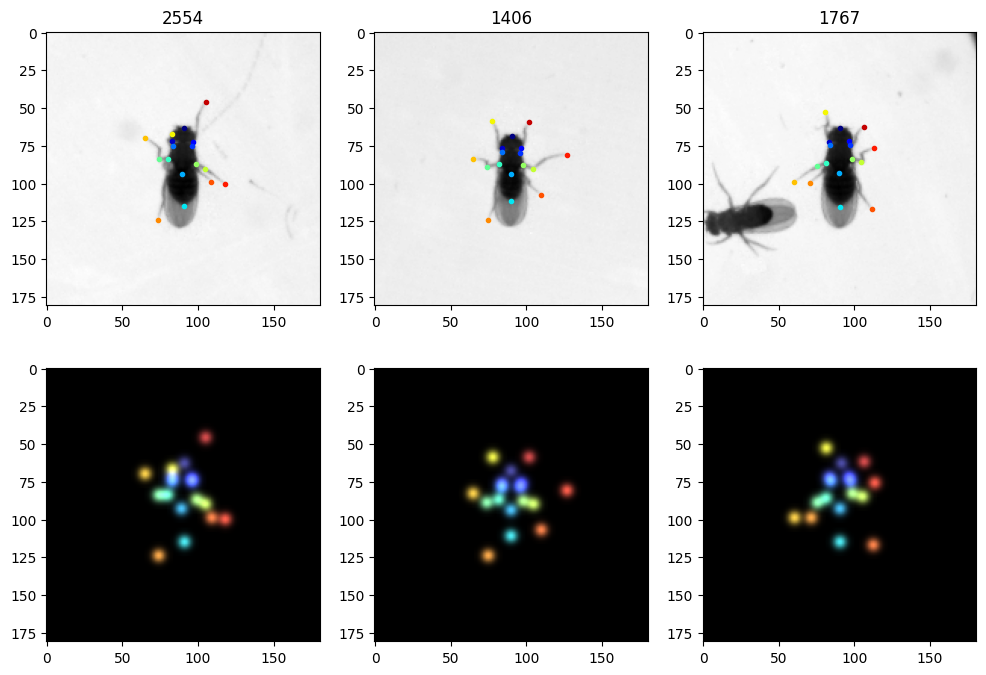

In [11]:
# instantiate train data loader

# only use a subset of the landmarks
#landmarks = np.where(list(map(lambda x: x in ['head_fc','leg_fl_tip','leg_fr_tip'],landmark_names)))[0]
# use all the landmarks
landmarks = None

train_dataset = COCODataset(trainannfile, datadir=traindir, landmarks=landmarks)
train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=2,
                                               shuffle=True)

# plot example images using the dataloader
fig = plt.figure(figsize=(nimsshow * 4, 8), dpi=100)

# choose some colors for each landmark
cmap = matplotlib.cm.get_cmap('jet')
colornorm = matplotlib.colors.Normalize(vmin=0, vmax=train_dataset.nlandmarks)
colors = cmap(colornorm(np.arange(train_dataset.nlandmarks)))

count = 0
for i_batch, sample_batch in enumerate(train_dataloader):
  for j in range(len(sample_batch['id'])):
    plt.subplot(2, nimsshow, count + 1)
    # use our helper functions for getting and formatting data from the batch
    im = COCODataset.get_image(sample_batch, j)
    locs = COCODataset.get_landmarks(sample_batch, j)
    plt.imshow(im, cmap='gray')
    for k in range(train_dataset.nlandmarks):
      plt.plot(locs[k, 0], locs[k, 1], marker='.', color=colors[k],
               markerfacecolor=colors[k])
    plt.title('%d'%sample_batch['id'][j])
    hmim = COCODataset.get_heatmap_image(sample_batch, j, colors=colors)
    plt.subplot(2, nimsshow, count + 1 + nimsshow)
    plt.imshow(hmim)
    count += 1
    if count >= nimsshow:
      break
  if count >= nimsshow:
    break

# Show the structure of a batch
print(sample_batch)

---
# Architectures

In [12]:
# Define network structure - UNet
# Copy-paste & modify from https://github.com/milesial/Pytorch-UNet

# The UNet is defined modularly.
# It is a series of downsampling layers defined by the module Down
# followed by upsampling layers defined by the module Up. The output is
# a convolutional layer with an output channel for each landmark, defined by
# the module OutConv.
# Each down and up layer is actually two convolutional layers with
# a ReLU nonlinearity and batch normalization, defined by the module
# DoubleConv.
# The Down module consists of a 2x2 max pool layer followed by the DoubleConv
# module.
# The Up module consists of an upsampling, either defined via bilinear
# interpolation (bilinear=True), or a learned convolutional transpose, followed
# by a DoubleConv module.
# The Output layer is a single 2-D convolutional layer with no nonlinearity.
# The nonlinearity is incorporated into the network loss function.

class DoubleConv(nn.Module):
  """(convolution => [BN] => ReLU) * 2"""

  def __init__(self, in_channels, out_channels, mid_channels=None):
    super().__init__()
    if not mid_channels:
        mid_channels = out_channels
    self.double_conv = nn.Sequential(
        nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(mid_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
        )

  def forward(self, x):
    return self.double_conv(x)


class Down(nn.Module):
  """Downscaling with maxpool then double conv"""

  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.maxpool_conv = nn.Sequential(
        nn.MaxPool2d(2),
        DoubleConv(in_channels, out_channels)
        )

  def forward(self, x):
    return self.maxpool_conv(x)


class Up(nn.Module):
  """Upscaling then double conv"""

  def __init__(self, in_channels, out_channels, bilinear=True):
    super().__init__()

    # if bilinear, use the normal convolutions to reduce the number of channels
    if bilinear:
      self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
      self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
    else:
      self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
      self.conv = DoubleConv(in_channels, out_channels)


  def forward(self, x1, x2):
    x1 = self.up(x1)
    # input is CHW
    diffY = x2.size()[2] - x1.size()[2]
    diffX = x2.size()[3] - x1.size()[3]

    x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                    diffY // 2, diffY - diffY // 2])
    # if you have padding issues, see
    # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
    # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
    x = torch.cat([x2, x1], dim=1)
    return self.conv(x)


class OutConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(OutConv, self).__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

  def forward(self, x):
    return self.conv(x)

# copy-pasted and modified from unet_model.py

class UNet(nn.Module):
  def __init__(self, n_channels, n_landmarks, bilinear=True):
    super(UNet, self).__init__()
    self.n_channels = n_channels
    self.n_landmarks = n_landmarks
    self.bilinear = bilinear
    self.nchannels_inc = 8

    # define the layers

    # number of channels in the first layer
    nchannels_inc = self.nchannels_inc
    # increase the number of channels by a factor of 2 each layer
    nchannels_down1 = nchannels_inc*2
    nchannels_down2 = nchannels_down1*2
    nchannels_down3 = nchannels_down2*2
    # decrease the number of channels by a factor of 2 each layer
    nchannels_up1 = nchannels_down3//2
    nchannels_up2 = nchannels_up1//2
    nchannels_up3 = nchannels_up2//2

    if bilinear:
      factor = 2
    else:
      factor = 1

    self.layer_inc = DoubleConv(n_channels, nchannels_inc)

    self.layer_down1 = Down(nchannels_inc, nchannels_down1)
    self.layer_down2 = Down(nchannels_down1, nchannels_down2)
    self.layer_down3 = Down(nchannels_down2, nchannels_down3//factor)

    self.layer_up1 = Up(nchannels_down3, nchannels_up1//factor, bilinear)
    self.layer_up2 = Up(nchannels_up1, nchannels_up2//factor, bilinear)
    self.layer_up3 = Up(nchannels_up2, nchannels_up3//factor, bilinear)

    self.layer_outc = OutConv(nchannels_up3//factor, self.n_landmarks)

  def forward(self, x, verbose=False):
    x1 = self.layer_inc(x)
    if verbose: print(f'inc: shape = {x1.shape}')
    x2 = self.layer_down1(x1)
    if verbose:print(f'inc: shape = {x2.shape}')
    x3 = self.layer_down2(x2)
    if verbose: print(f'inc: shape = {x3.shape}')
    x4 = self.layer_down3(x3)
    if verbose: print(f'inc: shape = {x4.shape}')
    x = self.layer_up1(x4, x3)
    if verbose: print(f'inc: shape = {x.shape}')
    x = self.layer_up2(x, x2)
    if verbose: print(f'inc: shape = {x.shape}')
    x = self.layer_up3(x, x1)
    if verbose: print(f'inc: shape = {x.shape}')
    logits = self.layer_outc(x)
    if verbose: print(f'outc: shape = {logits.shape}')

    return logits

  def output(self, x, verbose=False):
    return torch.sigmoid(self.forward(x, verbose=verbose))

  def __str__(self):
    s = ''
    s += 'inc: '+str(self.layer_inc)+'\n'
    s += 'down1: '+str(self.layer_down1)+'\n'
    s += 'down2: '+str(self.layer_down2)+'\n'
    s += 'down3: '+str(self.layer_down3)+'\n'
    s += 'up1: '+str(self.layer_up1)+'\n'
    s += 'up2: '+str(self.layer_up2)+'\n'
    s += 'up3: '+str(self.layer_up3)+'\n'
    s += 'outc: '+str(self.layer_outc)+'\n'
    return s

  def __repr__(self):
    return str(self)


def heatmap2landmarks(hms):
  idx = np.argmax(hms.reshape(hms.shape[:-2] + (hms.shape[-2]*hms.shape[-1], )),
                  axis=-1)
  locs = np.zeros(hms.shape[:-2] + (2, ))
  locs[...,1],locs[...,0] = np.unravel_index(idx,hms.shape[-2:])
  return locs

inc: shape = torch.Size([2, 8, 181, 181])
inc: shape = torch.Size([2, 16, 90, 90])
inc: shape = torch.Size([2, 32, 45, 45])
inc: shape = torch.Size([2, 32, 22, 22])
inc: shape = torch.Size([2, 16, 45, 45])
inc: shape = torch.Size([2, 8, 90, 90])
inc: shape = torch.Size([2, 4, 181, 181])
outc: shape = torch.Size([2, 17, 181, 181])


/tmp/ipython-input-10-67214949.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = matplotlib.cm.get_cmap(cmap)


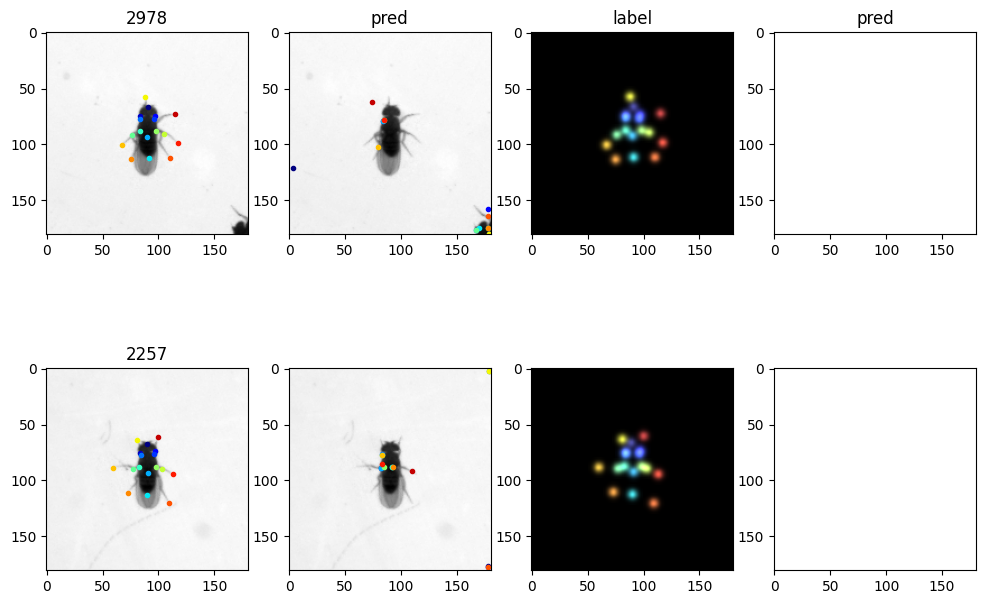

In [13]:
# Insantiate the network
net = UNet(n_channels=imsize[-1], n_landmarks=train_dataset.nlandmarks)
net.to(device=device) # have to be careful about what is done on the CPU vs GPU

# try the network out before training
batch = next(iter(train_dataloader))
with torch.no_grad():
  hms0 = net.output(batch['image'].to(device=device), verbose=True)

fig = plt.figure(figsize=(12, 4*len(batch['id'])), dpi= 100)
PlotLabelAndPrediction(batch, hms0)

In [14]:
# load a network if one is already saved and you want to restart training
# savefile = '/content/drive/My Drive/PoseEstimationNets/UNet20210510T140305/Final_epoch4.pth'
savefile = None
loadepoch = 0
# savefile = None
if savefile is not None:
  net.load_state_dict(
      torch.load(savefile, map_location=device)
      )
  m = re.search('[^\d](?P<epoch>\d+)\.pth$', savefile)
  if m is None:
    print('Could not parse epoch from file name')
  else:
    loadepoch = int(m['epoch'])
    print(f"Parsed epoch from loaded net file name: {loadepoch}")
  net.to(device=device)

In [25]:
# train the network
# following https://github.com/milesial/Pytorch-UNet/blob/master/train.py

# parameters related to training the network
batchsize = 2 # number of images per batch -- amount of required memory
              # for training will increase linearly in batchsize
nepochs = 3   # number of times to cycle through all the data during training
learning_rate = 0.005 # initial learning rate##改
weight_decay = 1e-8 # how learning rate decays over time
momentum = 0.9 # how much to use previous gradient direction
nepochs_per_save = 1 # how often to save the network
val_frac = 0.1 # what fraction of data to use for validation

# where to save the network
# make sure to clean these out every now and then, as you will run out of space
from datetime import datetime
now = datetime.now()
timestamp = now.strftime('%Y%m%dT%H%M%S')
# If you use your gDrive do not forget to set `gDrive` to `True`
if gDrive:
  savedir = '/content/drive/My Drive/PoseEstimationNets'
else:
  savedir = '/content/PoseEstimationNets'

# if the folder does not exist, create it.
if not os.path.exists(savedir):
  os.mkdir(savedir)

checkpointdir = os.path.join(savedir, 'UNet' + timestamp)
os.mkdir(checkpointdir)

# split into train and validation datasets
n_val = int(len(train_dataset) * val_frac)
n_train = len(train_dataset) - n_val
train, val = torch.utils.data.random_split(train_dataset, [n_train, n_val])
train_dataloader = torch.utils.data.DataLoader(train,
                                               batch_size=batchsize,
                                               shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val,
                                             batch_size=batchsize,
                                             shuffle=False)

# gradient descent flavor
optimizer = optim.RMSprop(net.parameters(),
                          lr=learning_rate,
                          weight_decay=weight_decay,
                          momentum=momentum)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)

# Following https://github.com/milesial/Pytorch-UNet
# Use binary cross entropy loss combined with sigmoid output activation function.
# We combine here for numerical improvements
criterion = nn.BCEWithLogitsLoss()

# store loss per epoch
epoch_losses = np.zeros(nepochs)
epoch_losses[:] = np.nan

# when we last saved the network
saveepoch = None

# how many gradient descent updates we have made
iters = loadepoch*len(train_dataloader)

# loop through entire training data set nepochs times
for epoch in range(loadepoch, nepochs):
  net.train() # put in train mode (affects batchnorm)
  epoch_loss = 0
  with tqdm(total=ntrainims,
            desc=f"Epoch {epoch + 1}/{nepochs}",
            unit='img') as pbar:

    # loop through each batch in the training data
    for batch in train_dataloader:
      # compute the loss
      imgs = batch['image']
      imgs = imgs.to(device=device, dtype=torch.float32) # transfer to GPU
      hm_labels = batch['heatmaps']
      hm_labels = hm_labels.to(device=device, dtype=torch.float32) # transfer to GPU
      hm_preds = net(imgs) # evaluate network on batch
      loss = criterion(hm_preds,hm_labels) # compute loss
      epoch_loss += loss.item()
      pbar.set_postfix(**{'loss (batch)': loss.item()})
      # gradient descent
      optimizer.zero_grad()
      loss.backward()
      nn.utils.clip_grad_value_(net.parameters(), 0.1)
      optimizer.step()
      iters += 1

      pbar.update(imgs.shape[0])
  print(f"loss (epoch) = {epoch_loss}")
  epoch_losses[epoch] = epoch_loss

  # save checkpoint networks every now and then
  if epoch % nepochs_per_save == 0:
    print(f"Saving network state at epoch {epoch + 1}")
    # only keep around the last two epochs for space purposes
    if saveepoch is not None:
      savefile0 = os.path.join(checkpointdir,
                               f"CP_latest_epoch{saveepoch+1}.pth")
      savefile1 = os.path.join(checkpointdir,
                               f"CP_prev_epoch{saveepoch+1}.pth")
      if os.path.exists(savefile0):
        try:
          os.rename(savefile0,savefile1)
        except:
          print(f"Failed to rename checkpoint file {savefile0} to {savefile1}")
    saveepoch = epoch
    savefile = os.path.join(checkpointdir,f"CP_latest_epoch{saveepoch + 1}.pth")
    torch.save(net.state_dict(),
               os.path.join(checkpointdir, f"CP_latest_epoch{epoch + 1}.pth"))

torch.save(net.state_dict(),
           os.path.join(checkpointdir, f"Final_epoch{epoch + 1}.pth"))

Epoch 1/3:  90%|█████████ | 3795/4216 [00:34<00:03, 111.03img/s, loss (batch)=0.00337]


loss (epoch) = 7.6552758403122425
Saving network state at epoch 1


Epoch 2/3:  90%|█████████ | 3795/4216 [00:32<00:03, 115.37img/s, loss (batch)=0.00354]


loss (epoch) = 6.737896009348333
Saving network state at epoch 2


Epoch 3/3:  90%|█████████ | 3795/4216 [00:34<00:03, 111.30img/s, loss (batch)=0.00348]


loss (epoch) = 6.597004109527916
Saving network state at epoch 3


/tmp/ipython-input-10-67214949.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = matplotlib.cm.get_cmap(cmap)


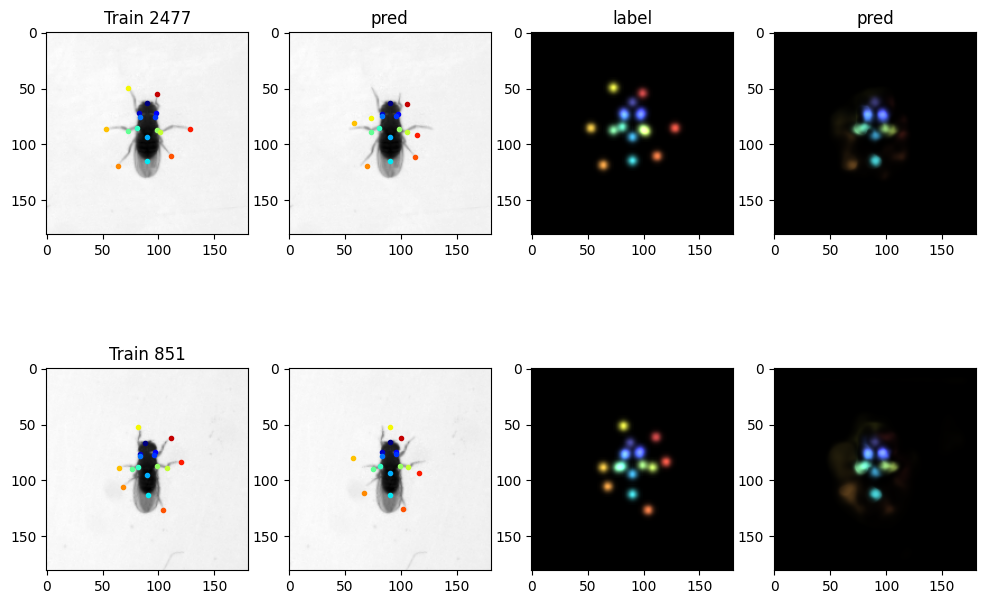

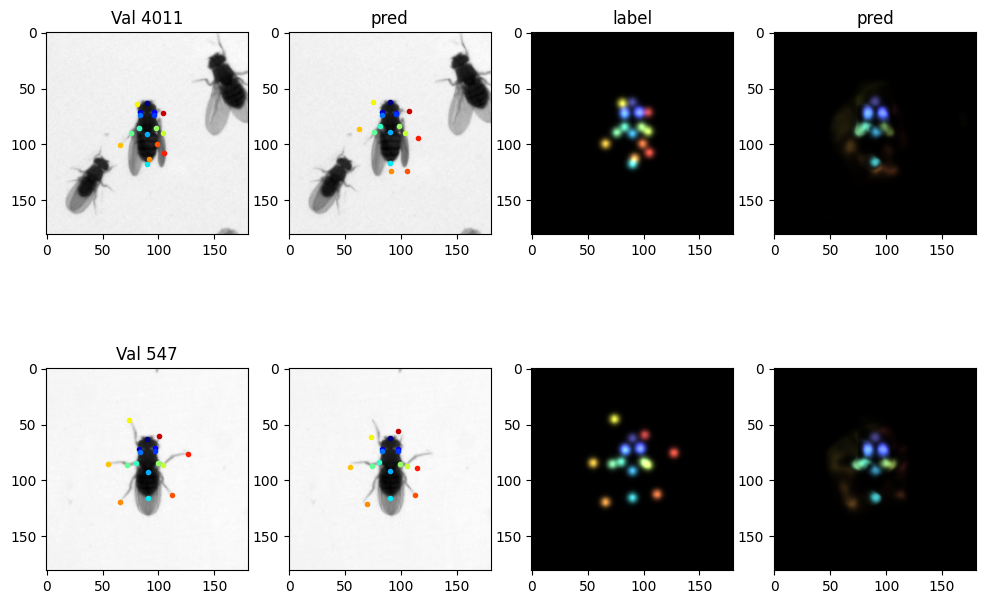

In [26]:
# try the trained network out on training and val images
net.eval()
batch = next(iter(train_dataloader))
with torch.no_grad():
  train_hms1 = torch.sigmoid(net(batch['image'].to(device)))

fig=plt.figure(figsize=(12, 4*train_hms1.shape[0]), dpi= 100)
PlotLabelAndPrediction(batch,train_hms1,title_string='Train ')

batch = next(iter(val_dataloader))
with torch.no_grad():
  val_hms1 = net.output(batch['image'].to(device))
fig = plt.figure(figsize=(12, 4 * val_hms1.shape[0]), dpi=100)
PlotLabelAndPrediction(batch, val_hms1, title_string='Val ')

---
# Evaluation

In [27]:
# Evaluate the training and validation error

def eval_net(net, loader):
  net.eval()
  n_val = len(loader) * loader.batch_size
  errs = None
  count = 0

  for batch in loader:

    with torch.no_grad():
      hm_preds = torch.sigmoid(net(batch['image'].to(device))).cpu().numpy()

    idx = np.argmax(hm_preds.reshape((hm_preds.shape[0],
                                      hm_preds.shape[1],
                                      hm_preds.shape[2] * hm_preds.shape[3])),
                    axis=2)
    loc_preds = np.zeros((hm_preds.shape[0], hm_preds.shape[1], 2))
    loc_preds[:, :, 1], loc_preds[:, :, 0] = np.unravel_index(idx,
                                                              hm_preds.shape[2:])

    loc_labels = batch['landmarks'].numpy()
    l2err = np.sqrt(np.sum((loc_preds - loc_labels)**2., axis=2))
    idscurr = batch['id'].numpy()

    if errs is None:
      errs = np.zeros((n_val, l2err.shape[1]))
      errs[:] = np.nan
      ids = np.zeros(n_val, dtype=int)

    errs[count:(count + l2err.shape[0]), :] = l2err
    ids[count:(count + l2err.shape[0])] = idscurr
    count += l2err.shape[0]

  errs = errs[:count, :]
  ids = ids[:count]

  net.train()

  return errs, ids


l2err_per_landmark_val, val_ids = eval_net(net, val_dataloader)
l2err_per_landmark_train, train_ids = eval_net(net, train_dataloader)

## Error distribution

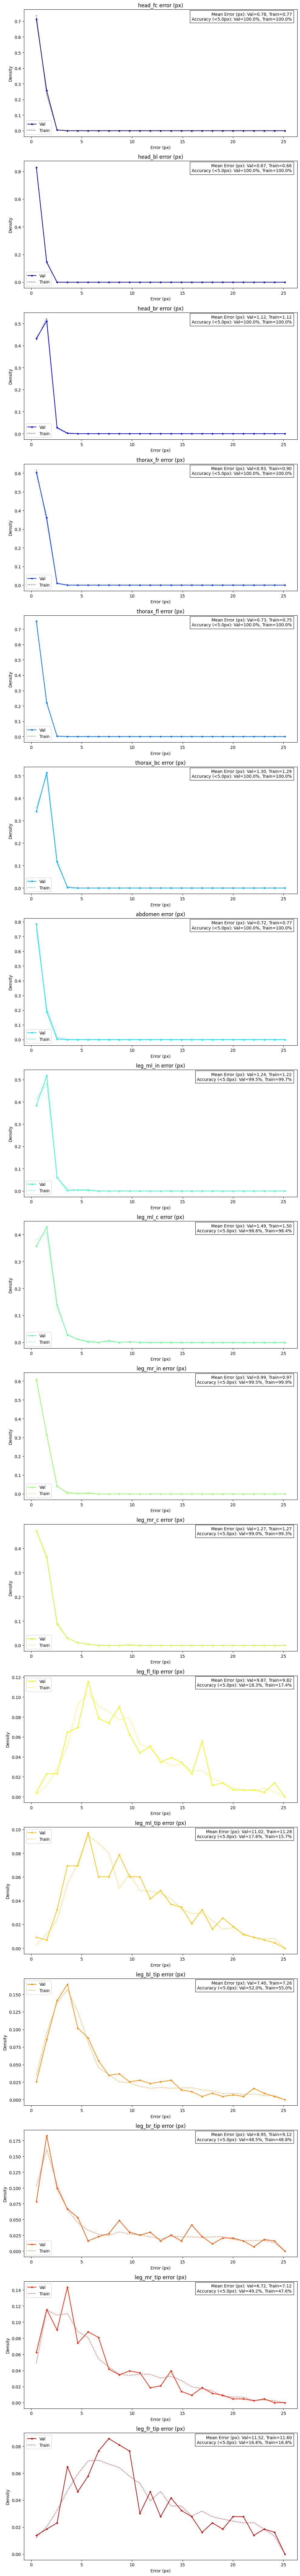

In [28]:
# Define threshold for accuracy (e.g., predictions with error < 5px are considered correct)
threshold_px = 5.0

# Calculate mean errors and accuracy
mean_err_val = np.mean(l2err_per_landmark_val, axis=0)
mean_err_train = np.mean(l2err_per_landmark_train, axis=0)

accuracy_val = np.mean(l2err_per_landmark_val < threshold_px, axis=0) * 100
accuracy_train = np.mean(l2err_per_landmark_train < threshold_px, axis=0) * 100

# Plot the error distribution with metrics
nbins = 25
bin_edges = np.linspace(0, np.percentile(l2err_per_landmark_val, 99.), nbins + 1)
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2.
bin_edges[-1] = np.inf

frac_val = np.zeros((nbins, l2err_per_landmark_val.shape[1]))
frac_train = np.zeros((nbins, l2err_per_landmark_val.shape[1]))

for i in range(l2err_per_landmark_val.shape[1]):
    frac_val[:, i], _ = np.histogram(l2err_per_landmark_val[:, i], bin_edges, density=True)
    frac_train[:, i], _ = np.histogram(l2err_per_landmark_train[:, i], bin_edges, density=True)

fig = plt.figure(figsize=(10, 5 * train_dataset.nlandmarks), dpi=100)

for i in range(train_dataset.nlandmarks):
    if landmarks is None:
        landmark_name = landmark_names[i]
    else:
        landmark_name = landmark_names[landmarks[i]]

    plt.subplot(train_dataset.nlandmarks, 1, i + 1)

    # Plot error distributions
    hval = plt.plot(bin_centers, frac_val[:, i], '.-', label='Val', color=colors[i, :])
    plt.plot(bin_centers, frac_train[:, i], ':', label='Train', color=colors[i, :])

    # Add mean error and accuracy as text
    text_str = '\n'.join((
        f'Mean Error (px): Val={mean_err_val[i]:.2f}, Train={mean_err_train[i]:.2f}',
        f'Accuracy (<{threshold_px}px): Val={accuracy_val[i]:.1f}%, Train={accuracy_train[i]:.1f}%'))

    plt.gca().text(0.98, 0.98, text_str,
                 transform=plt.gca().transAxes,
                 verticalalignment='top', horizontalalignment='right',
                 bbox=dict(facecolor='white', alpha=0.8))

    plt.legend()
    plt.title(f"{landmark_name} error (px)")
    plt.xlabel('Error (px)')
    plt.ylabel('Density')

plt.tight_layout()
plt.show()

/tmp/ipython-input-10-67214949.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = matplotlib.cm.get_cmap(cmap)


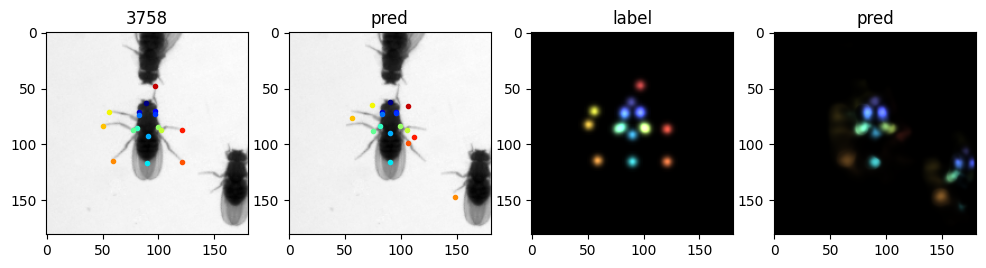

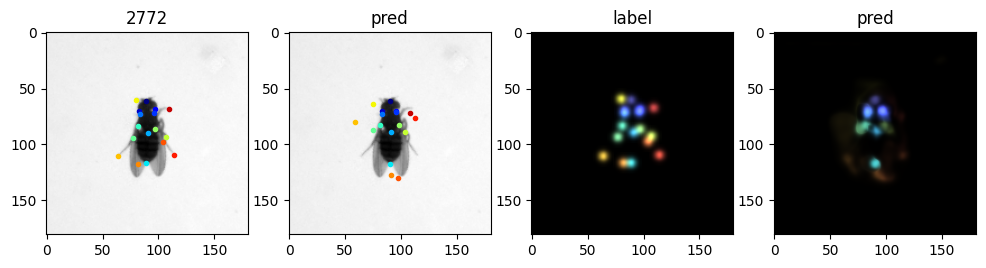

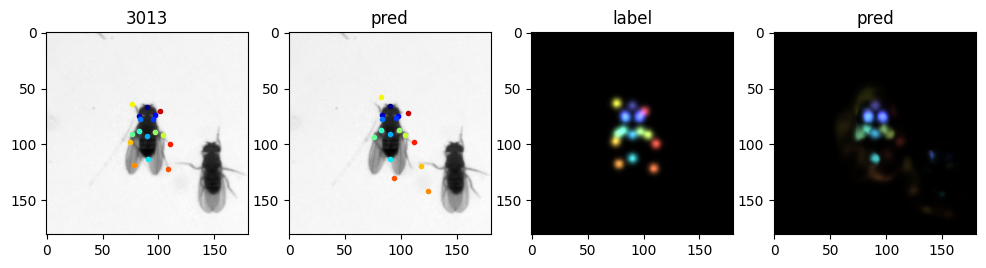

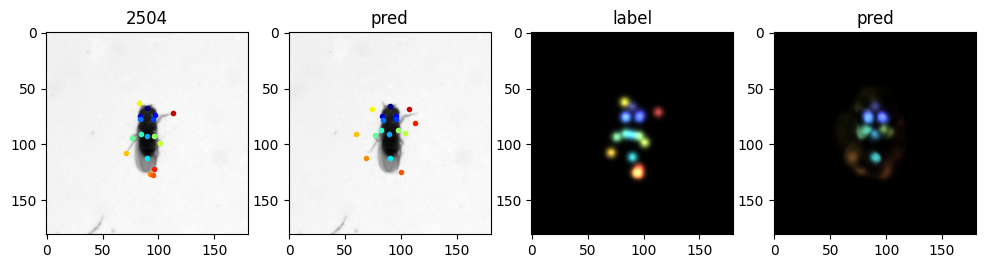

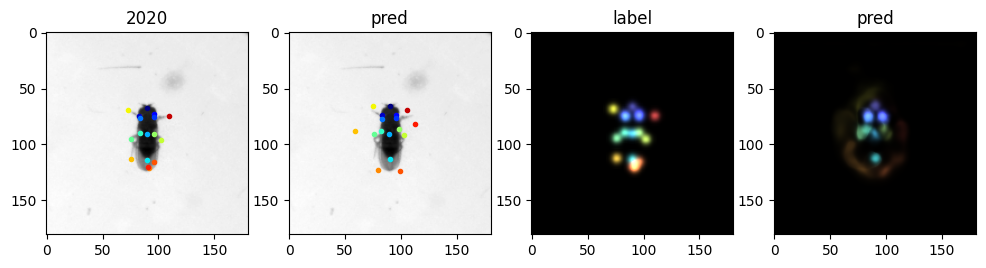

In [29]:
# Plot examples with big errors
idx = np.argsort(-np.sum(l2err_per_landmark_val, axis=1))

for i in range(5):
  d = train_dataset[val_ids[idx[i]]]
  img = d['image'].unsqueeze(0)
  net.eval()
  with torch.no_grad():
    pred = net.output(img.to(device))

  fig=plt.figure(figsize=(12, 4), dpi=100)
  with np.printoptions(precision=2):
    errstr = str(l2err_per_landmark_val[idx[i]])
  PlotLabelAndPrediction(d,pred[0, ...])  #,title_string='Err = %s '%errstr)

## Visulaization of layers

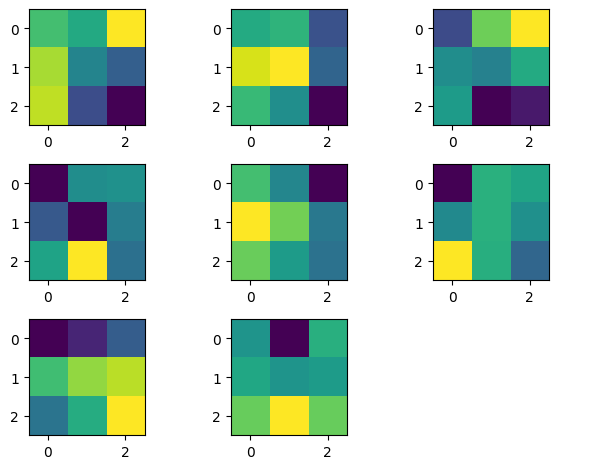

In [30]:
# Visualize the first layer of convolutional features
with torch.no_grad():
  w = net.layer_inc.double_conv[0].weight.cpu().numpy()
nr = int(np.ceil(np.sqrt(w.shape[0])))
nc = int(np.ceil(w.shape[0] / nr))
fig, ax = plt.subplots(nr, nc)
for i in range(w.shape[0]):
  r, c = np.unravel_index(i, (nr, nc))
  fil = np.transpose(w[i, :, :, :], [1, 2, 0])
  if fil.shape[-1] == 1:
    fil = fil[:, :, 0]
  ax[r][c].imshow(fil)
  plt.axis('off')
plt.tight_layout()
plt.show()

## Final evaluation on the test set

In [31]:
# final evaluation on the test set. for proper evaluation, and to avoid overfitting
# to the test set, we want to change parameters based on the validation set, and
# only at the very end evaluate on the test set

with open(testannfile) as f:
  testann = json.load(f)
f.close()
ntestims = len(testann['images'])
# Make sure we have all the images
t = glob(os.path.join(testdir, '*.png'))
print(f"N. test images = {ntestims}, number of images unzipped = {len(t)}")
assert ntestims==len(t), 'number of annotations and number of images do not match'

test_dataset = COCODataset(testannfile, datadir=testdir, landmarks=landmarks)
test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                              batch_size=2,
                                              shuffle=True)

l2err_per_landmark_test, test_ids = eval_net(net, test_dataloader)

N. test images = 1800, number of images unzipped = 1800


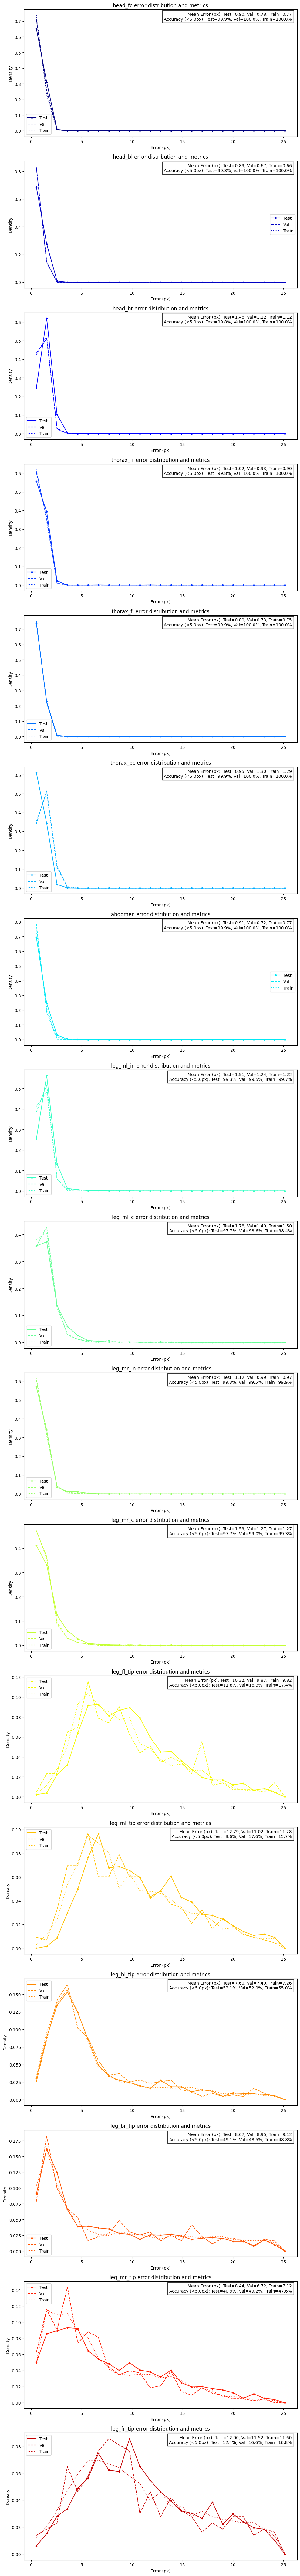

In [32]:
# Calculate mean errors and accuracy (assuming correct if error < threshold)
threshold_px = 5.0  # You can adjust this threshold for what you consider "correct"

# Calculate mean errors
mean_err_val = np.mean(l2err_per_landmark_val, axis=0)
mean_err_train = np.mean(l2err_per_landmark_train, axis=0)
mean_err_test = np.mean(l2err_per_landmark_test, axis=0)

# Calculate accuracy (percentage of predictions with error < threshold)
accuracy_val = np.mean(l2err_per_landmark_val < threshold_px, axis=0) * 100
accuracy_train = np.mean(l2err_per_landmark_train < threshold_px, axis=0) * 100
accuracy_test = np.mean(l2err_per_landmark_test < threshold_px, axis=0) * 100

# Plot the error distribution and metrics
nbins = 25
bin_edges = np.linspace(0, np.percentile(l2err_per_landmark_val, 99.),
                       nbins + 1)
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2.
bin_edges[-1] = np.inf
frac_val = np.zeros((nbins, l2err_per_landmark_val.shape[1]))
frac_train = np.zeros((nbins, l2err_per_landmark_val.shape[1]))
frac_test = np.zeros((nbins, l2err_per_landmark_val.shape[1]))
for i in range(l2err_per_landmark_val.shape[1]):
    frac_val[:, i], _ = np.histogram(l2err_per_landmark_val[:, i],
                                   bin_edges, density=True)
    frac_train[:, i], _ = np.histogram(l2err_per_landmark_train[:, i],
                                     bin_edges, density=True)
    frac_test[:, i], _ = np.histogram(l2err_per_landmark_test[:, i],
                                    bin_edges, density=True)

fig = plt.figure(figsize=(10, 5 * train_dataset.nlandmarks), dpi=100)
for i in range(train_dataset.nlandmarks):
    if landmarks is None:
        landmark_name = landmark_names[i]
    else:
        landmark_name = landmark_names[landmarks[i]]

    plt.subplot(train_dataset.nlandmarks, 1, i + 1)

    # Plot error distributions
    plt.plot(bin_centers, frac_test[:, i], '.-', label='Test', color=colors[i, :])
    plt.plot(bin_centers, frac_val[:, i], '--', label='Val', color=colors[i, :])
    plt.plot(bin_centers, frac_train[:, i], ':', label='Train', color=colors[i, :])

    # Add mean error and accuracy as text
    text_str = '\n'.join((
        f'Mean Error (px): Test={mean_err_test[i]:.2f}, Val={mean_err_val[i]:.2f}, Train={mean_err_train[i]:.2f}',
        f'Accuracy (<{threshold_px}px): Test={accuracy_test[i]:.1f}%, Val={accuracy_val[i]:.1f}%, Train={accuracy_train[i]:.1f}%'))

    plt.gca().text(0.98, 0.98, text_str,
                 transform=plt.gca().transAxes,
                 verticalalignment='top', horizontalalignment='right',
                 bbox=dict(facecolor='white', alpha=0.8))

    plt.legend()
    plt.title(f"{landmark_name} error distribution and metrics")
    plt.xlabel('Error (px)')
    plt.ylabel('Density')

plt.tight_layout()
plt.show()

/tmp/ipython-input-10-67214949.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = matplotlib.cm.get_cmap(cmap)


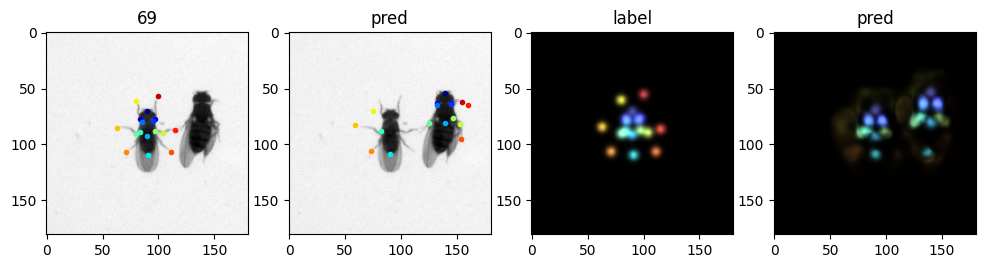

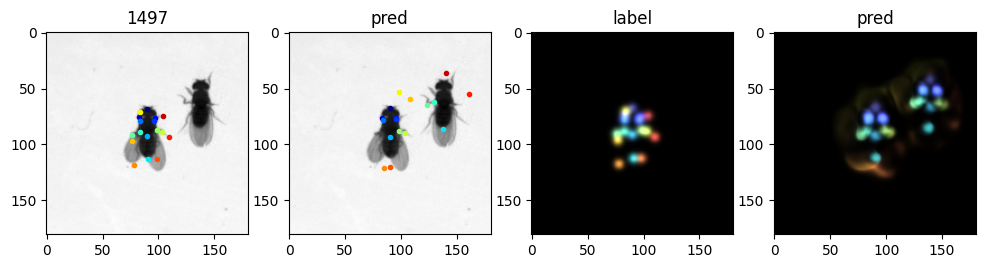

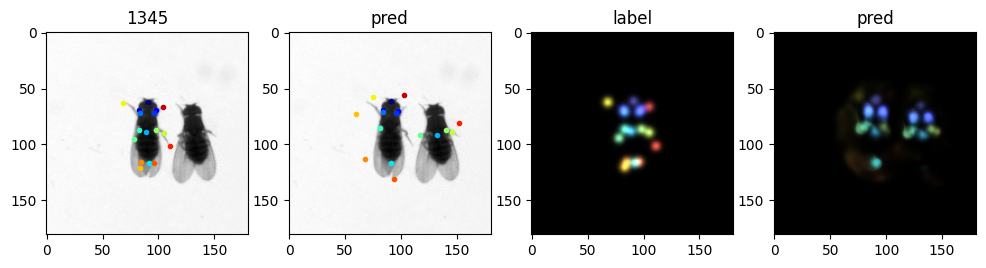

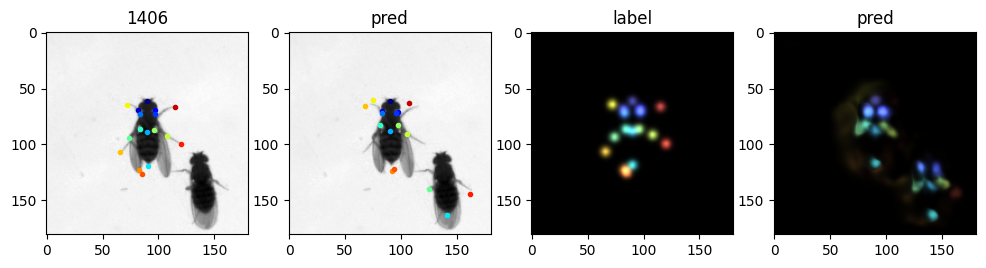

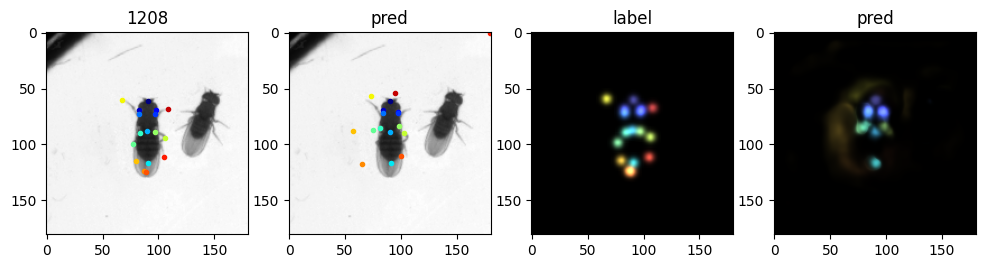

In [33]:
# Plot examples with big errors
idx = np.argsort(-np.sum(l2err_per_landmark_test, axis=1))

for i in range(5):
  d = test_dataset[test_ids[idx[i]]]
  img = d['image'].unsqueeze(0)
  net.eval()
  with torch.no_grad():
    pred = net.output(img.to(device))

  fig=plt.figure(figsize=(12, 4), dpi=100)
  with np.printoptions(precision=2):
    errstr = str(l2err_per_landmark_test[idx[i]])
  PlotLabelAndPrediction(d, pred[0, ...])  #,title_string='Err = %s '%errstr)